In [1]:
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import pandas as pd

from keras.datasets import fashion_mnist # import the necessary packages
from keras.utils import to_categorical # transfer label to one-hot

from keras.models import load_model
from keras.models import Model

from keras.backend import clear_session
from keras.models import Sequential 
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU
from keras.optimizers import Adam

from keras.preprocessing.image import img_to_array, array_to_img
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import tensorflow as tf 

clear_session()

Using TensorFlow backend.


In [2]:
def load_data():
    print('[INFO] loading Fashion MNIST...')
    ((trainX_ori, trainY_ori), (testX_ori, testY_ori)) = fashion_mnist.load_data()
    
    print('Train: X= %s, Y= %s' % (trainX_ori.shape, trainY_ori.shape))
    print('Test: X= %s, Y= %s' % (testX_ori.shape, testY_ori.shape))
    
    return trainX_ori, testX_ori, trainY_ori, testY_ori

def split_data(trainX_ori, testX_ori, trainY_ori, testY_ori, training_frac=0.8):
    
    print('\nSpliting data...')
    train_size = int( (len(trainX_ori)+len(testX_ori)) *training_frac ) 
    
    if len(trainX_ori) > train_size:
        trainX, trainY = trainX_ori[0:train_size], trainY_ori[0:train_size]
        testX, testY = np.concatenate((trainX_ori[train_size:], testX_ori), axis=0), np.concatenate((trainY_ori[train_size:],testY_ori), axis=0)
    else:
        s = train_size-len(trainX_ori)
        trainX, trainY = np.concatenate((trainX_ori[:], testX_ori[:s]), axis=0), np.concatenate((trainY_ori[:], testY_ori[:s]), axis=0)
        testX, testY = testX_ori[s:], testY_ori[s:]
        
    print('Train: X= %s, Y= %s' % (trainX.shape, trainY.shape))
    print('Test: X= %s, Y= %s' % (testX.shape, testY.shape))
    
    return trainX, testX, trainY, testY

def preprocess_data(trainX, testX, trainY, testY):
    print('\nPreprocessing data...')
    # normalization: scale the images to between 0-1
    trainX = trainX.astype('float32') / 255.0
    testX = testX.astype('float32') / 255.0
    
    # one-hot encode the training and testing labels
    trainY = to_categorical(trainY, 10)
    testY = to_categorical(testY, 10)
    
    # reshape
    trainX = trainX.reshape(-1, 28, 28, 1)  # -1 python auto-calculate
    testX = testX.reshape(-1, 28, 28, 1)
    ##print(trainX.shape)
    
    return trainX, testX, trainY, testY


def change_shape(x, size):
    # Change the shape to (48, 48, 3)
    
    x = np.reshape(x, (len(x), 28, 28, 1)) # Current shape (len, 28, 28, 1)
    x = tf.image.grayscale_to_rgb(tf.convert_to_tensor(x)) # Current shape (len, 28, 28, 3)
    x = np.array(tf.image.resize(x, [size, size])) # Current shape (size, size, 3)
    x = x / 255.  # Normalise the data and change data type
    x = x.astype('float32')
    
    return x

def preprocess_data_vgg(trainX, testX, trainY, testY):
    print('\nPreprocessing data...')
    
    # VGG16 must have exactly 3 input channels, convert the images into 3 channels
    trainX = change_shape(trainX, 72)
    testX = change_shape(testX, 72)
    
    # VGG16 preprocess
    trainX, testX = preprocess_input(trainX), preprocess_input(testX)
    #trainX = preprocess_input(trainX)
    
    # one-hot encode the training and testing labels
    trainY = to_categorical(trainY, 10)
    testY = to_categorical(testY, 10)
    
    return trainX, testX, trainY, testY

def train_CNN(trainX, trainY, testX, testY, model_name, batch_size=15, epochs=15):

    model = Sequential([
        Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2), strides=2),
        Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
        MaxPooling2D(pool_size=(2,2), strides=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # summary
    model.summary()
    
    # compile
    model.compile(optimizer='adam' , loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    # train
    history = model.fit(trainX, trainY, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

    test_loss, test_acc = model.evaluate(testX, testY)
    print("Model - test loss:", test_loss * 100)
    print("Model - test accuracy:", test_acc * 100)
    
    model.save("model//" + model_name) 

    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to csv: 
    hist_csv_file = "model//" + model_name + "_history.csv"
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def train_VGG16(trainX_vgg, trainY_vgg, testX_vgg, testY_vgg, model_name, batch_size=15, epochs=15):
    
    # vgg16
    clear_session()
    model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(72, 72, 3)) 
    # include_top=True，表示會載入完整的 VGG16 模型，包括加在最後3層的卷積層；include_top=False，表示會載入 VGG16 的模型，不包括加在最後3層的卷積層，通常是取得 Features

    # Creating dictionary that maps layer names to the layers
    layer_dict = dict([(layer.name, layer) for layer in model_vgg.layers])

    # Getting output tensor of the last VGG layer that we want to include
    x = layer_dict['block5_pool'].output

    # attach layers on top of VGG    
    x = Flatten()(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(2048, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)

    # New model (VGG + CNN)
    model_improved = Model(inputs = model_vgg.input, outputs = x)

    # pre-trained bottom layers are not trainable
    for layer in model_improved.layers[:len(layer_dict)+1]:
        layer.trainable = False

    # summary
    model_improved.summary()

    # compile
    model_improved.compile(optimizer='adam' , loss = 'categorical_crossentropy', metrics = ['accuracy'])

    # train
    history_improved = model_improved.fit(trainX_vgg, trainY_vgg, batch_size = 15, epochs = 15, validation_split = 0.2)
    imporved_test_loss, imporved_test_acc = model_improved.evaluate(testX_vgg, testY_vgg)

    print("Model imporved - test loss:", imporved_test_loss * 100)
    print("Model imporved - test accuracy:", imporved_test_acc * 100)

    model_improved.save("model//" + model_name)

    # convert the history.history dict to a pandas DataFrame:     
    hist_improved_df = pd.DataFrame(history_improved.history) 

    # save to csv: 
    hist_improved_csv_file = "model//history_" + model_name + ".csv"
    with open(hist_improved_csv_file, mode='w') as f:
        hist_improved_df.to_csv(f)
               
def history2plot(historydf):
    # Learning curve: summarize history for loss 
    plt.plot(historydf['loss']) 
    plt.plot(historydf['val_loss']) 
    plt.title('Learning Curve')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train loss', 'test loss'], loc='upper right') 
    plt.show()

    # summarize history for accuracy
    plt.plot(historydf['accuracy'])
    plt.plot(historydf['val_accuracy'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train acc', 'test acc'], loc='upper left') 
    plt.show()

def plot_first_conv(model, testX):
    # summarize feature map shapes
    for i in range(len(model.layers)):
        layer = model.layers[i]
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # summarize output shape
        #print(i, layer.name, layer.output.shape)

    # define a new model that outputs a feature map from the first convolutional layer (index 1) as follows.
    # redefine model to output right after the first hidden layer
    model_first_conv = Model(inputs = model.inputs, outputs = model.layers[1].output)
    model_first_conv.summary()
    
    # prepare the test image
    test_img = expand_dims(testX[0], axis=0)
    #print(test_img.shape)
    #print(test_img)

    # get feature map for first hidden layer
    feature_maps = model_first_conv.predict(test_img)
    #print(feature_maps.shape)
    
    # plot activations of the first layer
    ix = 1
    length = int(feature_maps.shape[3]/4)

    plt.figure(figsize=(10,10))
    for i in range(1, 5):
        for j in range(1, length+1):
            # specify subplot and turn of axis
            ax = plt.subplot(4, length, ix)  # argument: 1(the number of plots in each row), 2(the number of plots per column)

            ax.set_xticks([])
            ax.set_yticks([])

            # plot filter channel in black&white style
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='binary')
            ix += 1

    plt.show()
    
def plot_image(i, predictions_array, true_label, img):
    true_label, img = np.argmax(true_label[i]), img[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.squeeze(), cmap='binary')

    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(labelNames[predicted_label],
                                100*np.max(predictions_array),
                                labelNames[true_label]),
                                color=color)
    
def plot_prediction(testX, testY, predY):
    # Plot the sample images now
    f, ax = plt.subplots(4,4,figsize=(10,10))
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    ix = 1
    true_label_list = []
    pred_label_list = []
    
    ramdom_sample_list = np.random.permutation(np.arange(len(testY)))[:16]
    
    for i in range(16):
        index = ramdom_sample_list[i]
        true_label, img = np.argmax(testY[index]), testX[index]
        #true_label_list.append(true_label)
        
        ax = plt.subplot(4, 4, ix)  # argument: 1(the number of plots in each row), 2(the number of plots per column)

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        
        predicted_label = np.argmax(predY[index])
        #pred_label_list.append(predicted_label) 
    
        if predicted_label == true_label:
            ax.text(0.5, 0.9, labelNames[predicted_label], ha='center', va='center', transform=ax.transAxes, color='lime', size=16)
        
        else:
            ax.text(0.5, 0.9, labelNames[predicted_label], ha='center', va='center', transform=ax.transAxes, color='red', size=16)
          
        plt.imshow(img.squeeze(), cmap='gray')
        ix += 1
    
    f.subplots_adjust(wspace=0, hspace=0)
    plt.show()   

In [3]:
# load data from fashion_mnist
trainX_ori, testX_ori, trainY_ori, testY_ori = load_data()

# split data into 80 %/20 % for training/testing
trainX, testX, trainY, testY = split_data(trainX_ori, testX_ori, trainY_ori, testY_ori, training_frac=0.8)
trainX, testX, trainY, testY = preprocess_data(trainX, testX, trainY, testY)

print("Train: X=", trainX.shape, ", Y=", trainY.shape)
print("Test: X=", testX.shape, ", Y=", testY.shape)

[INFO] loading Fashion MNIST...
Train: X= (60000, 28, 28), Y= (60000,)
Test: X= (10000, 28, 28), Y= (10000,)

Spliting data...
Train: X= (56000, 28, 28), Y= (56000,)
Test: X= (14000, 28, 28), Y= (14000,)

Preprocessing data...
Train: X= (56000, 28, 28, 1) , Y= (56000, 10)
Test: X= (14000, 28, 28, 1) , Y= (14000, 10)


In [4]:
# initialize the label names
labelNames = ["Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [ ]:
train_CNN(trainX, trainY, testX, testY)

In [5]:
loaded_model = load_model('model\CNN_model')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1568)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                100416    
_________________________________________________________________
dense_2 (Dense)              (None, 10)               

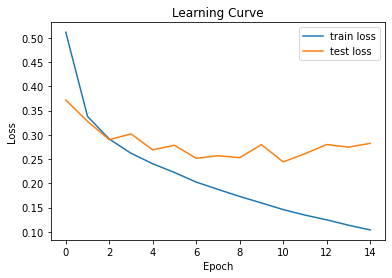

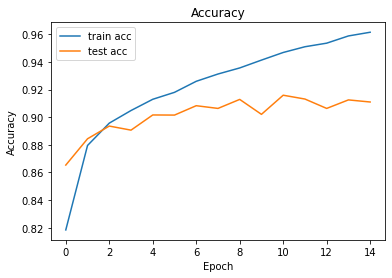

In [6]:
hist_df_read = pd.read_csv('model\history.csv',index_col=0)
history2plot(hist_df_read)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
Total params: 160
Trainable params: 160
Non-trainable params: 0
_________________________________________________________________


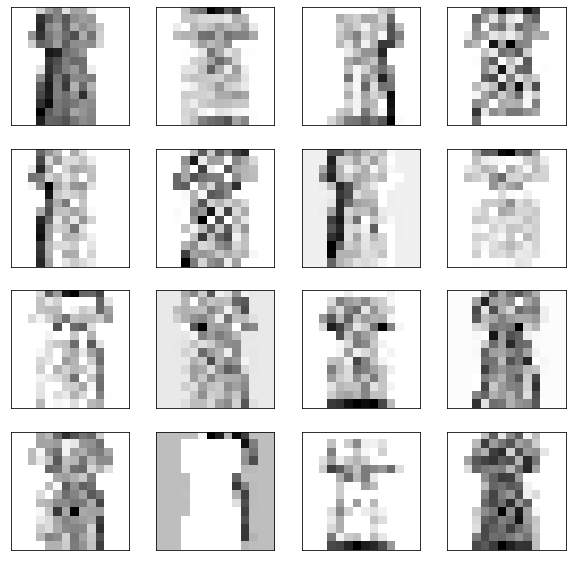

In [7]:
plot_first_conv(loaded_model, testX)

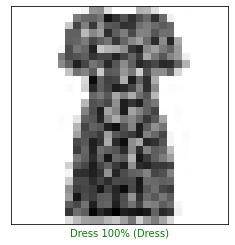

In [8]:
# plot corresponding image with the prediction and label
predict_output = loaded_model.predict(testX) # test_img

plot_image(0, predict_output[0], testY, testX)

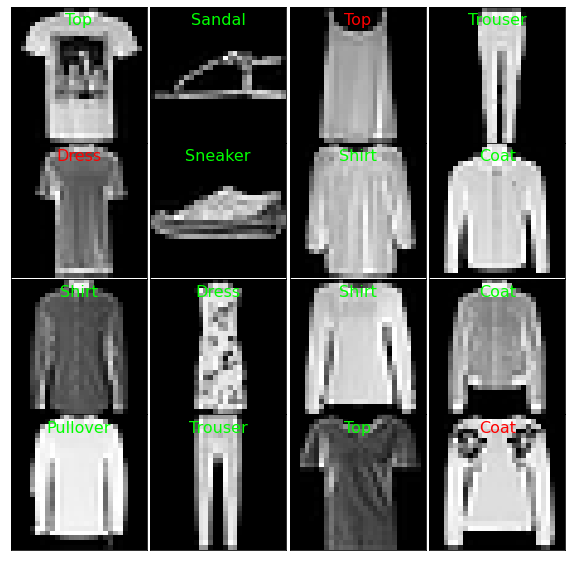

In [10]:
predict_output = loaded_model.predict(testX) # test_img
plot_prediction(testX, testY, predict_output)

In [11]:
# load data from fashion_mnist
trainX_ori, testX_ori, trainY_ori, testY_ori = load_data()
# print(trainX_ori.shape)

# split data into 80 %/20 % for training/testing
trainX, testX, trainY, testY = split_data(trainX_ori, testX_ori, trainY_ori, testY_ori, training_frac=0.8)
trainX_vgg, testX_vgg, trainY_vgg, testY_vgg = preprocess_data_vgg(trainX, testX, trainY, testY)

print("Train_vgg: X=", trainX_vgg.shape, ", Y_vgg=", trainY_vgg.shape)
print("Test_vgg: X=", testX_vgg.shape, ", Y_vgg=", testY_vgg.shape)

[INFO] loading Fashion MNIST...
Train: X= (60000, 28, 28), Y= (60000,)
Test: X= (10000, 28, 28), Y= (10000,)

Spliting data...
Train: X= (56000, 28, 28), Y= (56000,)
Test: X= (14000, 28, 28), Y= (14000,)

Preprocessing data...
Train_vgg: X= (56000, 72, 72, 3) , Y_vgg= (56000, 10)
Test_vgg: X= (14000, 72, 72, 3) , Y_vgg= (14000, 10)


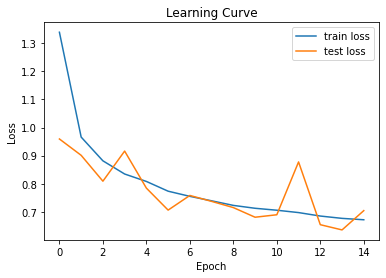

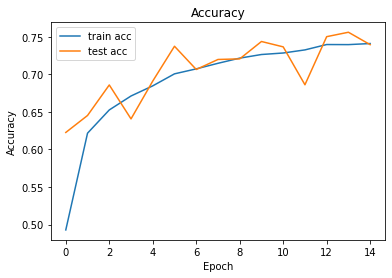

In [12]:
hist_improved_df_read = pd.read_csv('model\history_improved.csv', index_col=0)
history2plot(hist_improved_df_read)

In [4]:
loaded_improved_model = load_model('model\VGG_model')
loaded_improved_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0   

In [5]:
predict_output_vgg = loaded_improved_model.predict(testX_vgg) # test_img

In [6]:
def plot_first_conv_vgg(model, testX):
    # summarize feature map shapes
    for i in range(len(model.layers)):
        layer = model.layers[i]
        
        # check for convolutional layer
        if 'conv' not in layer.name:
            continue
        
        # summarize output shape
        #print(i, layer.name, layer.output.shape)

    # define a new model that outputs a feature map from the first convolutional layer (index 1) as follows.
    # redefine model to output right after the first hidden layer
    model_first_conv = Model(inputs = model.inputs, outputs = model.layers[1].output)
    model_first_conv.summary()
    
    # prepare the test image
    test_img = expand_dims(testX[0], axis=0)
    print(test_img.shape)
    #print(test_img)

    # get feature map for first hidden layer
    feature_maps = model_first_conv.predict(test_img)
    print(feature_maps.shape)
    
    # plot activations of the first layer
    ix = 1
    length = int(feature_maps.shape[3]/4)

    plt.figure(figsize=(25,25))
    for i in range(1, 5):
        for j in range(1, length+1):
            # specify subplot and turn of axis
            ax = plt.subplot(4, length, ix)  # argument: 1(the number of plots in each row), 2(the number of plots per column)

            ax.set_xticks([])
            ax.set_yticks([])

            # plot filter channel in black&white style
            plt.imshow(feature_maps[0, :, :, ix-1], cmap='binary')
            ix += 1

    plt.show()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
Total params: 1,792
Trainable params: 0
Non-trainable params: 1,792
_________________________________________________________________
(1, 72, 72, 3)
(1, 72, 72, 64)


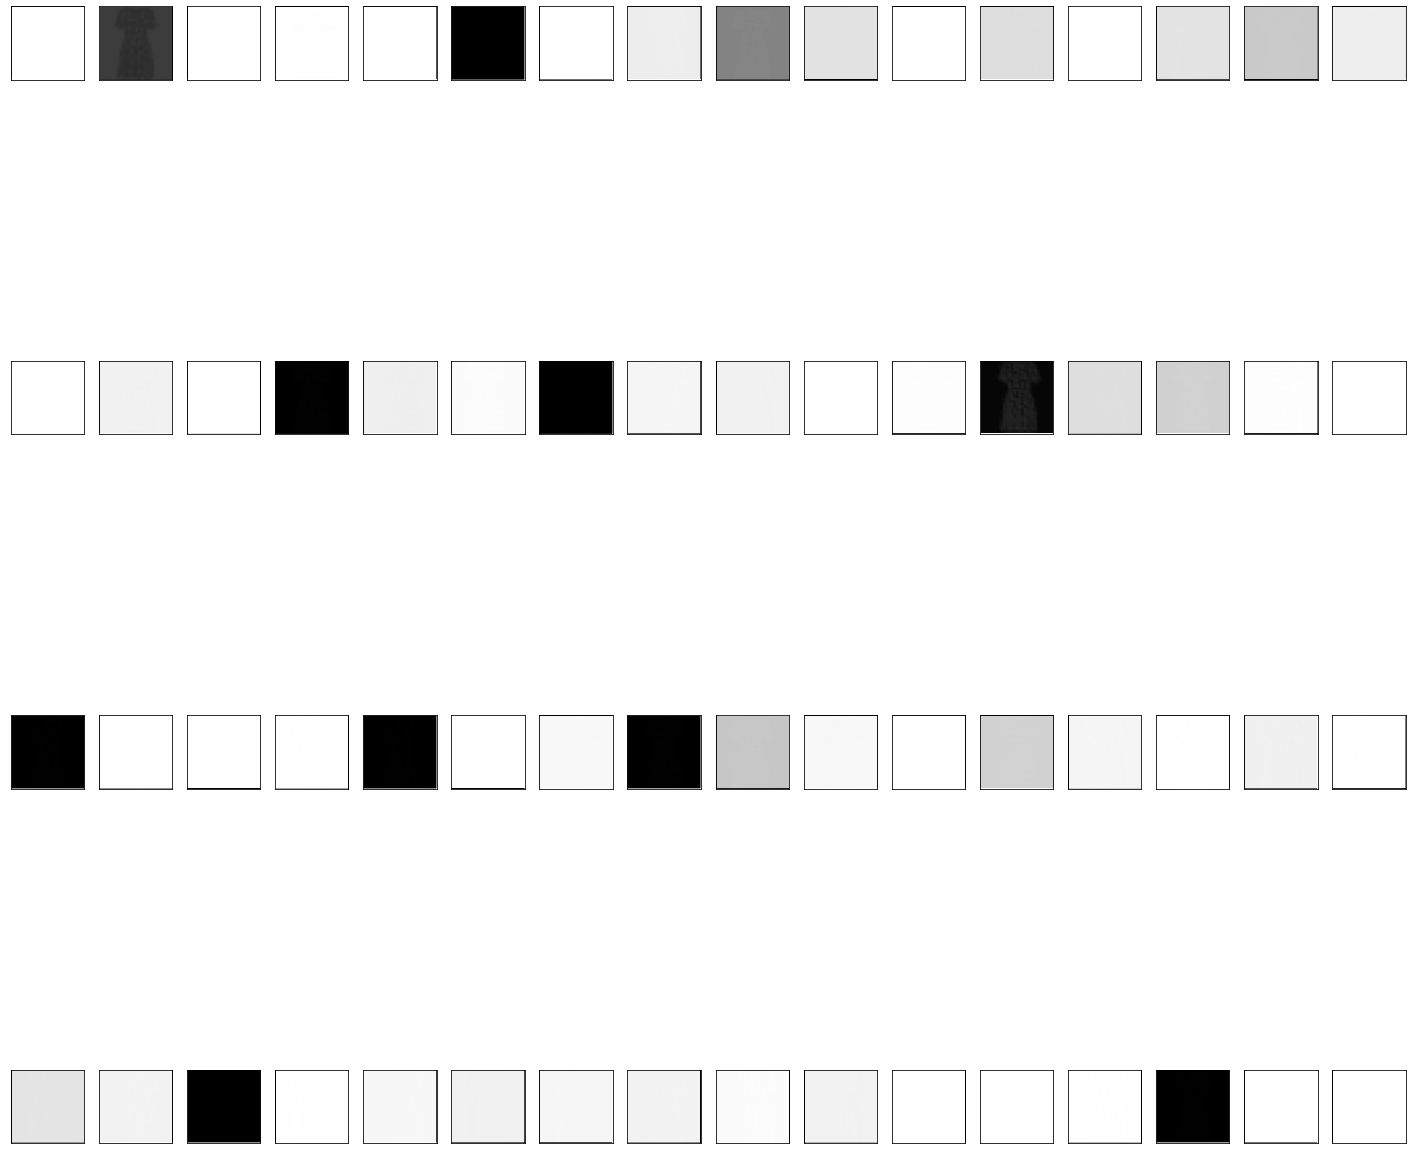

In [17]:
plot_first_conv_vgg(loaded_improved_model, testX_vgg)

In [8]:
def plot_image_vgg(i, predictions_array, true_label, img):
    true_label, img = np.argmax(true_label[i]), img[i]
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
#     img = np.clip(img, 0, 1)
#     img = img.astype(np.uint8)
    
    plt.imshow(img.squeeze(), cmap='binary') # , cmap='binary'

    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(labelNames[predicted_label],
                                100*np.max(predictions_array),
                                labelNames[true_label]),
                                color=color)

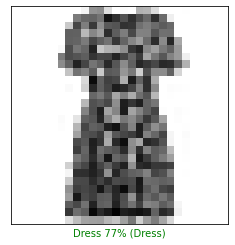

In [15]:
plot_image_vgg(0, predict_output_vgg[0], testY_vgg, testX)

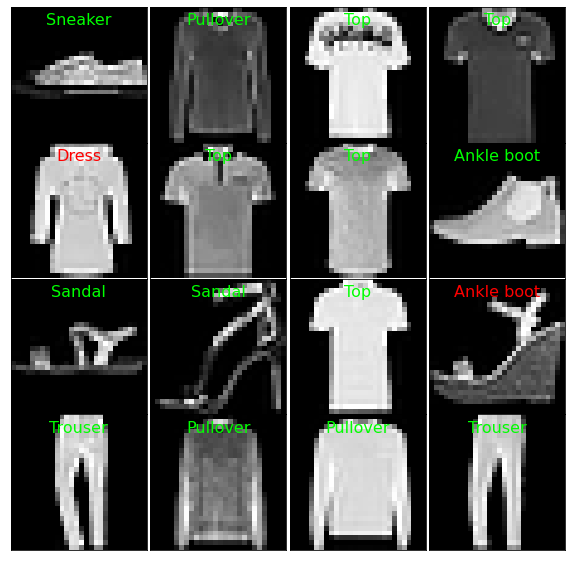

In [14]:
plot_prediction(testX, testY_vgg, predict_output_vgg)